In [4]:
import pandas as pd

emails = pd.read_excel("yammer_emails.xlsx")

events = pd.read_excel("yammer_events.xlsx")

users = pd.read_excel("yammer_users.xlsx")

In [5]:
print(emails.info())
print(events.info())
print(users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90389 entries, 0 to 90388
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      90389 non-null  int64         
 1   occurred_at  90389 non-null  datetime64[ns]
 2   action       90389 non-null  object        
 3   user_type    90389 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 2.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340832 entries, 0 to 340831
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   user_id      340832 non-null  int64         
 1   occurred_at  340832 non-null  datetime64[ns]
 2   event_type   340832 non-null  object        
 3   event_name   340832 non-null  object        
 4   location     340832 non-null  object        
 5   device       340832 non-null  object        
 6   user_type

In [6]:
from pandas_profiling import ProfileReport
profile = ProfileReport(emails, title='Pandas Profiling Report')
profile.to_file(output_file='emails.html')
profile = ProfileReport(events, title='Pandas Profiling Report')
profile.to_file(output_file='events.html')
profile = ProfileReport(users, title='Pandas Profiling Report')
profile.to_file(output_file='users.html')


In [10]:
user_events = users.merge(events, on = 'user_id', suffixes = ('_usr', '_events'))
df = user_events.merge(emails, on = 'user_id', suffixes = ('_usr_events', '_emails'))

In [11]:
profile = ProfileReport(df, title='df')
profile.to_file(output_file='df.html')

The first thing to look into is

In [17]:
df['created_at'] = df['created_at'].dt.date
df['activated_at'] = df['activated_at'].dt.date
df['occurred_at_usr_events'] = df['occurred_at_usr_events'].dt.date

In [22]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import style
style.use('seaborn-white')

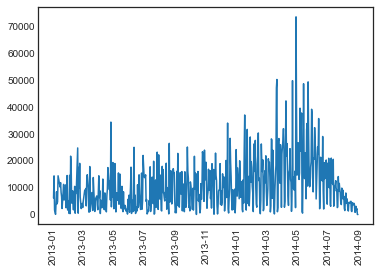

In [26]:
df_usr_count = df.groupby(['created_at'])['user_id'].count()
df_usr_count.plot(x='created_at', y='user_id', rot= 90)
plt.xlabel("")
plt.show()

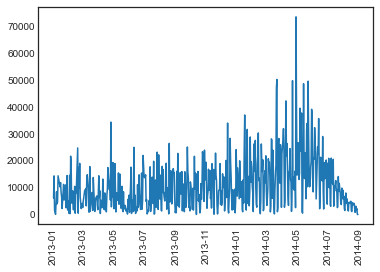

In [27]:
df_act_count = df.groupby(['activated_at'])['user_id'].count()
df_act_count.plot(x='activated_at', y='user_id', rot= 90)
plt.xlabel("")
plt.show()

Are events happening as before?

In [39]:
df_event_count = df.groupby(['occurred_at_usr_events','event_name'])['user_id'].count()
df_event_count = df_event_count.reset_index()

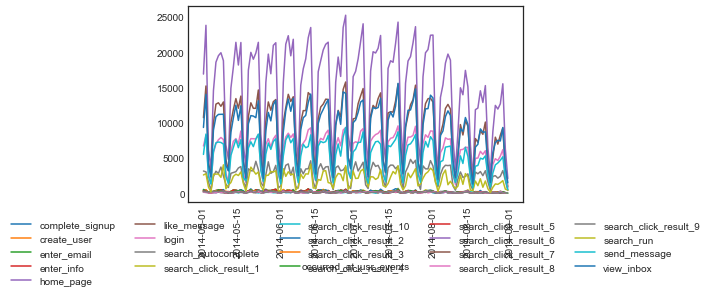

In [45]:
fig, ax = plt.subplots()

for key, data in df_event_count.groupby('event_name'):
    data.plot(x='occurred_at_usr_events', y='user_id',ax = ax, label=key, rot = 90)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.show()